# Deep Gaussian Process Regression Model

#### Mark Pullin (27th March 2019)

## Introduction
This notebooks demonstrates the usage of deep Gaussian process models in MXFusion. The particular deep Gaussian process model used in this notebook is described in [Doubly Stochastic Variational Inference for Deep Gaussian Processes (Hugh Salimbeni, Marc Deisenroth)](https://arxiv.org/abs/1705.08933). Variational inference is used and the evidence lower bound is approximated using mini-batches and the reparameterization trick. 

In this notebook we will fit a step function with a deep GP model.

In [1]:
FIG_SIZE = (12, 8)
import numpy as np
N = 50
X = np.linspace(-5, 5, N)[:, None]
Y = (X > 0).astype(float)

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=FIG_SIZE)
plt.title('Step Function')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.plot(X, Y);

# MXFusion model

We now define a 3-layer mxfusion deep Gaussian process model, making use of the `mxfusion.modules.gp_modules.DeepGPRegression` module.

For each layer of the model, we need to define a set of inducing points and a kernel. In this simple example, the input and output dimensionality of each layer is set to 1.

In [3]:
import mxfusion
import numpy as np
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

/Users/marpulli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
import mxnet as mx
import mxfusion.components.distributions.gp.kernels
from mxfusion.components.variables import PositiveTransformation
from mxfusion.modules.gp_modules.dgp import DeepGPRegression

M = 10
D = 1
z_locations = np.linspace(-5, 5, 10)[:, None]
m = mxfusion.Model()
m.N = mxfusion.Variable()
m.X = mxfusion.Variable(shape=(m.N, D))
m.Z_0 = mxfusion.Variable(shape=(M, D), initial_value=mx.nd.array(z_locations))
m.Z_1 = mxfusion.Variable(shape=(M, D), initial_value=mx.nd.array(z_locations))

# this is the likelihood noise at the final layer
m.noise_var = mxfusion.Variable(transformation=PositiveTransformation())

kernels = [mxfusion.distributions.gp.kernels.RBF(D), 
           mxfusion.distributions.gp.kernels.RBF(D)]
m.Y = DeepGPRegression.define_variable(m.X, kernels, m.noise_var, shape=(m.N, 1), 
                                       inducing_inputs=[m.Z_0, m.Z_1], 
                                       n_samples=5)

# Run inference
We can use the `MAP` inference algorithm to find the variational parameters, kernel hyperparameters and likelihood noise that maximise the ELBO.

In [15]:
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), max_iter=1000, 
         learning_rate=0.05, verbose=True)

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 101 loss: -15.003117274942323
Iteration 201 loss: -39.424766543253033
Iteration 301 loss: -49.522606480687446
Iteration 401 loss: -52.539479366628765
Iteration 501 loss: -59.426992754574024
Iteration 601 loss: -70.723104089698545
Iteration 701 loss: -72.721547843770035
Iteration 801 loss: -69.331084234133675
Iteration 901 loss: -72.019873122987066
Iteration 1000 loss: -50.651192380623336

# Prediction

The `TransferInference` is used together with the `ModulePredictionAlgorithm` to produce mean and variance predictions at new x locations.

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


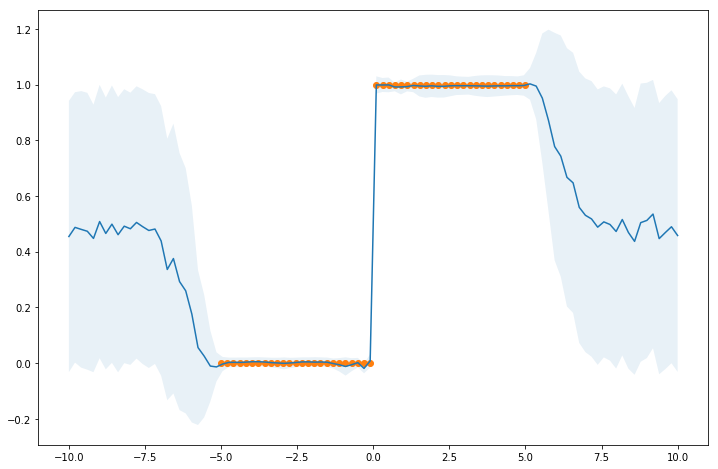

In [19]:
from mxfusion.inference import ModulePredictionAlgorithm, TransferInference
xt = np.linspace(-10, 10, 100)[:, None]

# More samples to give smoother plots
m.Y.factor.dgp_predict.n_samples = 500
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)

res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

mean = res[0].asnumpy()[:, 0]
plt.plot(xt, res[0].asnumpy())

std = np.sqrt(res[1].asnumpy())[:, 0]
plt.fill_between(xt[:, 0], mean - std, mean + std, alpha=0.1)
plt.scatter(X, Y)